In [1]:
from datetime import datetime
import folium
from folium import plugins
from folium.plugins import HeatMap
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import Point, LineString
from geographiclib.geodesic import Geodesic
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pyffp import calc_footprint_FFP as myfootprint
from pyffp import calc_footprint_FFP_climatology as myfootprintclim

from pyffp.utils import get_dd
from pyffp.utils import contour_to_gdf
import geopy
from geopy.distance import geodesic

plt.style.use('dark_background')

In [2]:
def read_l3(filepath, datecol='DATE'):
    df = (pd.read_csv(filepath, header=0, low_memory=False)
      .replace(-9999, np.nan)
      .assign(date = lambda x: pd.to_datetime(x[datecol]))
      .set_index('date', drop=False)
     )
    df.index = df.index.set_names(None)
    return df

filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L3_2023-04-25.csv'
l3 = read_l3(filepath)

predictors = 'baseflux'
filepath = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/ATMOS_20230425_{predictors}/gapfilled/rf_predictors_laplace.csv'
rf = read_l3(filepath).add_suffix('_RF')

filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L1_fluxnet_2023-04-10.csv'
l1_fluxnet = read_l3(filepath)

l3['V_SIGMA'] = l1_fluxnet.loc[l1_fluxnet.index == l3.index, 'V_SIGMA']
l3 = pd.concat([l3, rf.loc[:,'FCH4_F_RF':]], axis=1)

soil_dateformat = 'yyyy-mm-dd HH:MM:SS+00.00' # from ATMOS484 package

### Soil sensor grid

Locations of data loggers are taken from Zentra cloud website manually (can be saved to a csv). The azimuth of the grid's latitudinal axis is estimated from the logger locations. We project an 8x8 grid of 12.5m squares, with logger 6 at the center (4,4).

Sensor numbers and data loggers read from ATMOS_SoilSensors_layout.xlsx, from Alexis Renchon (uploaded to Google Drive folder "ATMOS Flux Data").



In [3]:
filepath = '/home/otto/data/atmos-flux-data/input/ATMOS_SoilSensors_layout.xlsx - Sheet1.csv'

dataloggers = pd.read_csv(filepath, usecols=[0, 1, 2, 3, 4], header=0, 
                          names=['logger', 'serial', 'status', 'lat', 'lon']).dropna()
dataloggers = gpd.GeoDataFrame(dataloggers, 
                               geometry=gpd.points_from_xy(dataloggers['lon'], dataloggers['lat']),
                               crs=4326)
# dataloggers.plot(column='logger')

geod = Geodesic.WGS84

A = dataloggers.geometry[3]
B = dataloggers.geometry[0]
inv = geod.Inverse(A.y,A.x,B.y,B.x)
azib = inv['azi1']
print('Azimuth from logger 0 to 3 = ' + str(azib))

A = dataloggers.geometry[10]
B = dataloggers.geometry[7]
inv = geod.Inverse(A.y,A.x,B.y,B.x)
azit = inv['azi1']
print('Azimuth from logger 7 to 10 = ' + str(azit))
azi = np.mean([azib, azit])

center = dataloggers.geometry[5] # projecting from center, logger 6

s = 50 - 6.5 # m
direct = geod.Direct(center.y,center.x,azi,s)
leftmidpt = (direct['lat2'],direct['lon2'])

direct = geod.Direct(leftmidpt[0],leftmidpt[1],azi-90,s)
origin = (direct['lat2'],direct['lon2'])
print('Origin = ' + str(origin))

Azimuth from logger 0 to 3 = -66.67909064882072
Azimuth from logger 7 to 10 = -66.51445741226922
Origin = (41.70131583022141, -87.99745859087017)


## Make a geodataframe of soil sensor locations by logger

In [4]:
sensors = pd.read_csv(filepath, usecols=[5, 6, 7, 8, 9, 10, 11], header=0, 
                      names=['logger', 'serial', 'status', 'port', 'teros_num', 'x', 'y'])

cols = ['logger', 'serial', 'status']
sensors.loc[:, cols] = sensors.loc[:, cols].ffill()

sensors = sensors.sort_values(by=['x','y'])

yax = np.array([geod.Direct(origin[0], origin[1], azi+90, s*12.5) for s in range(0, 8)])

xax = np.array([geod.Direct(origin[0], origin[1], azi-180, s*12.5) for s in range(0, 8)])

sensors.loc[sensors['y']==0, 'lat'] = [xax[x]['lat2'] for x in range(8)]
sensors.loc[sensors['y']==0, 'lon'] = [xax[x]['lon2'] for x in range(8)]
sensors.loc[sensors['x']==0, 'lat'] = [yax[y]['lat2'] for y in range(8)]
sensors.loc[sensors['x']==0, 'lon'] = [yax[y]['lon2'] for y in range(8)]

for i in range(1,8):
    row = np.array([geod.Direct(yax[i]['lat2'], yax[i]['lon2'], azi-180, s*12.5) for s in range(0, 8)])
    row
    sensors.loc[sensors['y']==i, 'lat'] = [row[x]['lat2'] for x in range(8)]
    sensors.loc[sensors['y']==i, 'lon'] = [row[x]['lon2'] for x in range(8)]

    
# sensors.loc[:,'zone'] = [0,0,1,1,2,2,3,3,0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,8,8,9,9,10,10,11,11,12,12,13,13,14,14,15,15,12,12,13,13,14,14,15,15]
# sensors.loc[:,'zone'] = [0,0,4,4,8,8,12,12,0,0,4,4,8,8,12,12,1,1,5,5,9,9,13,13,1,1,5,5,9,9,13,13,2,2,6,6,10,10,14,14,2,2,6,6,10,10,14,14,3,3,7,7,11,11,15,15,3,3,7,7,11,11,15,15]
sensors.loc[:, 'zone'] = sensors['x'] // 2 + 4 * (sensors['y'] // 2)


sensors = gpd.GeoDataFrame(sensors, 
                               geometry=gpd.points_from_xy(sensors['lon'], sensors['lat']),
                               crs=4326)

In [5]:
zones = sensors.dissolve(by=['zone'], as_index=False)
# zones.drop(columns=['serial', 'port', 'logger', 'teros_num', 'status'])

zonesm = zones.to_crs(3174)
# zonesm.geometry = zonesm.geometry.convex_hull.buffer(distance=6.25, cap_style=1, quad_segs=1)
zonesm.geometry = zonesm.geometry.convex_hull.apply(lambda g: g.buffer(distance=6.25, cap_style=3, join_style=2))

zones = zonesm.to_crs(4326)

In [6]:
# fig, ax = plt.subplots()

# zones.plot(color = 'red', alpha = 0.6, ax=ax)

# sensors.plot(column = 'zone', cmap='viridis',
#              legend=True,
#              ax=ax)
# dataloggers.plot(color = 'black', ax=ax)

# Monthly footprints

In [7]:
datestart = '2023-03'
dateend = datestart

## Read Zentra soil sensor data

In [8]:
met = read_l3('/home/otto/data/atmos-flux-data/output/atmos484_20230328_biomet.csv', datecol='date')

# df = met.loc[datestart:dateend, :]

df = met

def read_soil(df, column):
    
    df = df.loc[:, df.columns.str.match(f'{column}_([0-9]+)([0-9]+)(?!cm)')]
    df = df.melt(var_name='sensor', value_name=column, ignore_index=False)
    xy = df.loc[:, 'sensor'].str.extract(f'{column}([0-9]+)([0-9]+)').rename(columns={0:'x', 1:'y'}).astype('int64')
    df = pd.concat([df, xy], axis=1)
    df = df.merge(sensors[['x','y','lat','lon']], on=['x','y']).set_index(df.index)

    return df

soilT = df.loc[:, df.columns.str.match('Tsoil_([0-9]+)([0-9]+)(?!cm)')]

diff_max = 0.5

# bad_diff = soilT.where((abs(soilT.diff()) > diff_max) | (abs(soilT - soilT.mean(axis=1)) > 10))

# for col in soilT.columns:
#     if any(bad_diff[col]):
#         start = bad_diff[col].first_valid_index()
#         stop = bad_diff[col].last_valid_index()
#         soilT.loc[start:stop, col] = np.nan * np.ones(len(soilT.loc[start:stop]))
# #         soilT.loc[start:stop, col] = np.nan
#         print(f'Removed {col} from {start} to {stop}')

for col in soilT.columns:
    if any(abs(soilT[col].diff() > diff_max)):
        start = soilT[col].where(abs(soilT[col].diff()) > diff_max).first_valid_index()
        stop = soilT[col].where(abs(soilT[col].diff()) > diff_max).last_valid_index()
        soilT.loc[start:stop, col] = np.nan * np.ones(len(soilT.loc[start:stop]))
#         soilT.loc[start:stop, col] = np.nan
        print(f'Removed {col} from {start} to {stop}')

# soilT = soilT.where((abs(soilT.diff()) < 0.5) & (soilT < 25))

soilT = soilT.melt(var_name='Tsoil_sensor', value_name='Tsoil', ignore_index=False)

xy = soilT.loc[:, 'Tsoil_sensor'].str.extract('Tsoil_([0-9]+)([0-9]+)').rename(columns={0:'x', 1:'y'}).astype('int64')
soilT = pd.concat([soilT, xy], axis=1)

soilT = soilT.merge(sensors[['x','y','lat','lon','zone']], on=['x','y']).set_index(soilT.index)
soilT

soilM = df.loc[:, df.columns.str.match('SWC_([0-9]+)([0-9]+)(?!cm)')]
soilM = soilM.melt(var_name='SWC_sensor', value_name='SWC', ignore_index=False)

xy = soilM.loc[:, 'SWC_sensor'].str.extract('SWC_([0-9]+)([0-9]+)').rename(columns={0:'x', 1:'y'}).astype('int64')
soilM = pd.concat([soilM, xy], axis=1)

soilM = soilM.merge(sensors[['x','y','lat','lon','zone']], on=['x','y']).set_index(soilM.index)

soil = pd.concat([soilT, soilM[['SWC', 'SWC_sensor']]], axis=1)
soil.loc[:, 'date'] = soil.index
soil = gpd.GeoDataFrame(soil, 
                        geometry=gpd.points_from_xy(soil['lon'], soil['lat']),
                        crs=4326).sort_values(by=['date','y','x'])

# soil.sort_values(['Tsoil_sensor','date']).groupby(['Tsoil_sensor'])['Tsoil'].diff() > 1

# soil = soil.sort_values(['Tsoil_sensor','date'])

for sensor in soil['Tsoil_sensor'].unique():
    if any(soil.loc[soil['Tsoil_sensor']==sensor, 'Tsoil'].diff() > diff_max):
        print(sensor)        
soil

/tmp/ipykernel_14277/3660893510.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soilT.loc[start:stop, col] = np.nan * np.ones(len(soilT.loc[start:stop]))


Removed Tsoil_17 from 2022-11-09 04:30:00 to 2023-01-31 23:00:00
Removed Tsoil_15 from 2022-12-22 20:00:00 to 2023-01-07 12:30:00
Removed Tsoil_65 from 2022-10-14 06:30:00 to 2022-11-07 07:30:00
Removed Tsoil_66 from 2022-09-15 06:30:00 to 2022-10-22 05:30:00
Removed Tsoil_77 from 2022-12-24 07:30:00 to 2023-02-01 06:00:00


,Tsoil_sensor,Tsoil,x,y,lat,lon,zone,SWC,SWC_sensor,date,geometry
2022-05-23 05:00:00,Tsoil_00,NaN,0,0,41.701316,-87.997459,0,NaN,SWC_00,2022-05-23 05:00:00,POINT (-87.99746 41.70132)
2022-05-23 05:00:00,Tsoil_10,14.0,1,0,41.701271,-87.997321,0,0.381016,SWC_10,2022-05-23 05:00:00,POINT (-87.99732 41.70127)
2022-05-23 05:00:00,Tsoil_20,NaN,2,0,41.701226,-87.997183,1,NaN,SWC_20,2022-05-23 05:00:00,POINT (-87.99718 41.70123)
2022-05-23 05:00:00,Tsoil_30,14.0,3,0,41.701182,-87.997045,1,0.381016,SWC_30,2022-05-23 05:00:00,POINT (-87.99705 41.70118)
2022-05-23 05:00:00,Tsoil_40,NaN,4,0,41.701137,-87.996907,2,NaN,SWC_40,2022-05-23 05:00:00,POINT (-87.99691 41.70114)
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27 17:00:00,Tsoil_37,NaN,3,7,41.701905,-87.996628,13,NaN,SWC_37,2023-03-27 17:00:00,POINT (-87.99663 41.70190)
2023-03-27 17:00:00,Tsoil_47,NaN,4,7,41.701860,-87.996490,14,NaN,SWC_47,2023-03-27 17:00:00,POINT (-87.99649 41.70186)
2023-03-27 17:00:00,Tsoil_57,NaN,5,7,41.701815,-87.996352,14,NaN,SWC_57,2023-03-27 17:00:00,POINT (-87.99635 41.70182)
2023-03-27 17:00:00,Tsoil_67,NaN,6,7,41.701771,-87.996214,15,NaN,SWC_67,2023-03-27 17:00:00,POINT (-87.99621 41.70177)


<Axes: >

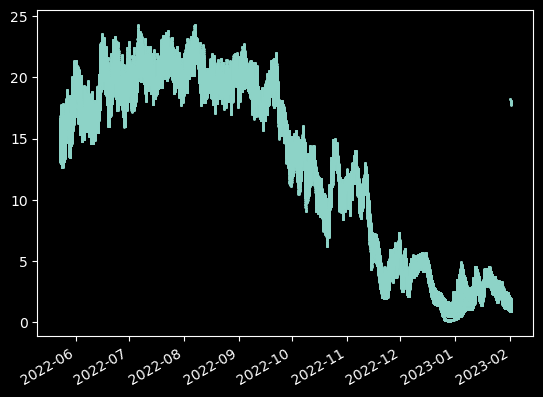

In [9]:
soil['Tsoil'].plot(marker='.', linestyle='', markersize=2)

In [10]:
soil.loc[:, ['Tsoil_QC', 'SWC_QC']] = np.zeros((len(soil),2))
# soil['Tsoil_QC'].where(soil['Tsoil'].diff()>1)
# soil.loc[]

In [11]:
bad_sensors_Tsoil = [sensor for sensor in soil['Tsoil_sensor'].unique() if any(soil.loc[soil['Tsoil_sensor']==sensor, 'Tsoil'].diff() > 0.25)]
print(bad_sensors_Tsoil)

['Tsoil_50', 'Tsoil_42', 'Tsoil_13', 'Tsoil_33', 'Tsoil_53', 'Tsoil_63', 'Tsoil_04', 'Tsoil_34', 'Tsoil_54', 'Tsoil_17', 'Tsoil_57']


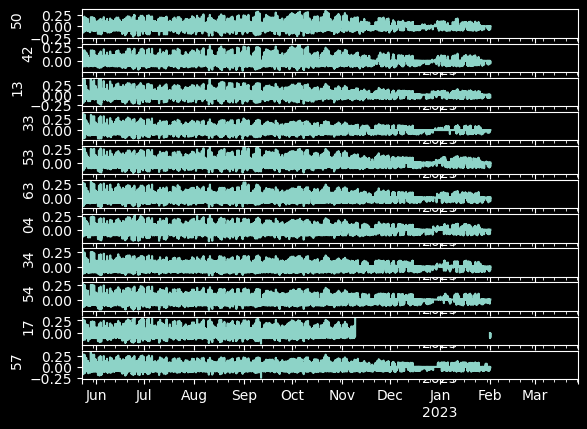

In [12]:
fig, ax = plt.subplots(len(bad_sensors_Tsoil))

for i in range(len(bad_sensors_Tsoil)):
    soil.loc[soil['Tsoil_sensor']==bad_sensors_Tsoil[i], 'Tsoil'].diff().plot(ax=ax[i])
    ax[i].set_ylabel(bad_sensors_Tsoil[i][6:8], loc='top')

<Axes: >

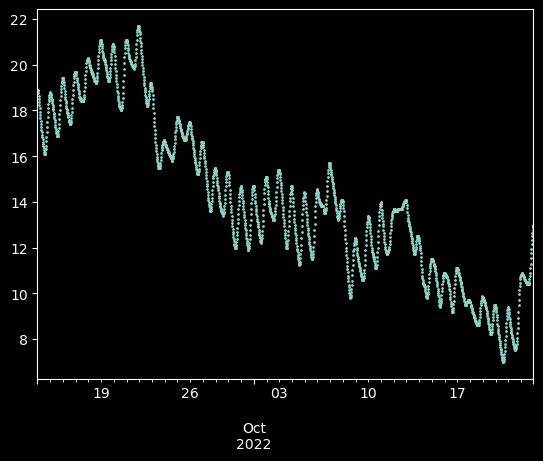

In [13]:
df = soil.loc['2022-09-14':'2022-10-22', :]
df.loc[df['Tsoil_sensor']==bad_sensors_Tsoil[2], 'Tsoil'].plot(linestyle = '', marker = '.', markersize = 2)
# df.loc[df['Tsoil_sensor']==bad_sensors_Tsoil[2], 'Tsoil'].diff().plot(linestyle = '', marker = '.', markersize = 2)

In [14]:
df.loc[df['Tsoil_sensor']==bad_sensors_Tsoil[2], 'Tsoil'].diff() > 1

2022-09-14 00:00:00    False
2022-09-14 00:30:00    False
2022-09-14 01:00:00    False
2022-09-14 01:30:00    False
2022-09-14 02:00:00    False
                       ...  
2022-10-22 21:30:00    False
2022-10-22 22:00:00    False
2022-10-22 22:30:00    False
2022-10-22 23:00:00    False
2022-10-22 23:30:00    False
Name: Tsoil, Length: 1872, dtype: bool

In [15]:
soil.loc[:, ['Tsoil', 'Tsoil_sensor']]

,Tsoil,Tsoil_sensor
2022-05-23 05:00:00,NaN,Tsoil_00
2022-05-23 05:00:00,14.0,Tsoil_10
2022-05-23 05:00:00,NaN,Tsoil_20
2022-05-23 05:00:00,14.0,Tsoil_30
2022-05-23 05:00:00,NaN,Tsoil_40
...,...,...
2023-03-27 17:00:00,NaN,Tsoil_37
2023-03-27 17:00:00,NaN,Tsoil_47
2023-03-27 17:00:00,NaN,Tsoil_57
2023-03-27 17:00:00,NaN,Tsoil_67


In [16]:
soil = soil.sort_values(by=['date','y','x'])

In [17]:
# monthly = soil.groupby([soil.date.dt.month, 'zone'])[['Tsoil', 'SWC']].mean()
# monthly = soil.resample('M').agg(Tsoil=('Tsoil', np.mean), SWC=('SWC', np.mean))
monthly = soil.groupby([soil.date.dt.to_period('M'), 'zone']).agg(Tsoil=('Tsoil', np.mean), SWC=('SWC', np.mean)).reset_index().set_index('date')
monthly.loc['2022-06']

,zone,Tsoil,SWC
date,,,
2022-06,0,17.445417,0.299912
2022-06,1,17.445417,0.299912
2022-06,2,18.621377,0.317648
2022-06,3,18.649663,0.316163
2022-06,4,18.535211,0.284072
2022-06,5,18.596282,0.304076
2022-06,6,18.774825,0.313207
2022-06,7,18.822271,0.321825
2022-06,8,18.517901,0.298866


In [18]:
zones = sensors.dissolve(by=['zone'], as_index=False)
# zones.drop(columns=['serial', 'port', 'logger', 'teros_num', 'status'])

zonesm = zones.to_crs(3174)
# zonesm.geometry = zonesm.geometry.convex_hull.buffer(distance=6.25, cap_style=1, quad_segs=1)
zonesm.geometry = zonesm.geometry.convex_hull.apply(lambda g: g.buffer(distance=6.25, cap_style=3, join_style=2))

zones = zonesm.to_crs(4326)

zones = zones.merge(soil.groupby('zone')[['Tsoil', 'SWC']].mean(), on='zone')

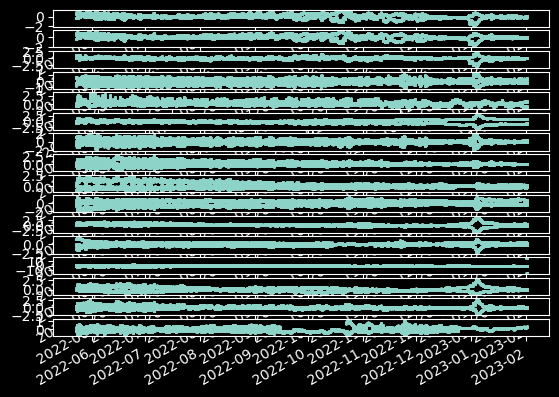

In [19]:
fig, ax = plt.subplots(16)
for z in soil['zone'].unique():
    soil.loc[soil['zone']==z, 'Tsoil'].diff().plot(linestyle='', marker='.', markersize=2, ax=ax[z])

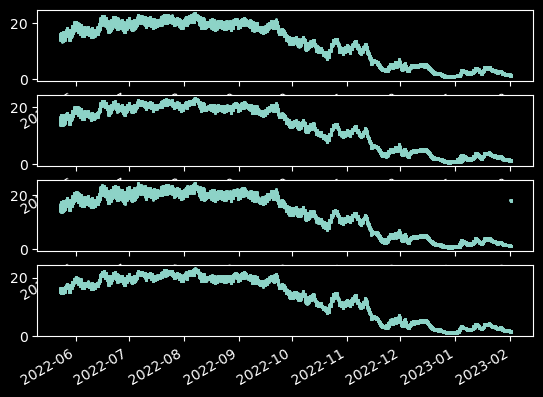

In [20]:
fig, ax = plt.subplots(4)
zs = [8,11,12,15]

for i in range(len(zs)):
    soil.loc[soil['zone']==zs[i], 'Tsoil'].plot(linestyle='', marker='.', markersize=2, ax=ax[i])
    
# soil.loc[soil['zone'].isin(zs),'Tsoil_sensor'].unique()

# fig, ax = plt.subplots(16)

# for sensor in soil.loc[soil['zone'].isin(zs),'Tsoil_sensor'].unique():
#     soil.loc[soil['Tsoil_sensor']==sensor, 'Tsoil'].plot(linestyle='', marker='.', markersize=2, ax=ax[])

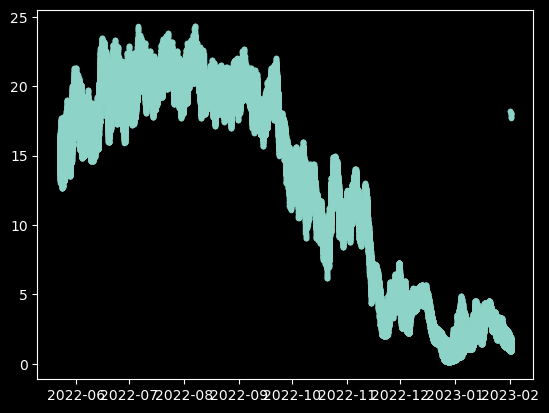

In [21]:
fig, ax = plt.subplots()

ax.plot(soil['date'], soil['Tsoil'], linestyle='', marker = '.')

In [22]:
# fig, ax = plt.subplots()
# zones.plot(column='Tsoil', legend=True, ax = ax)
# soil.plot(column = 'Tsoil', cmap = 'viridis',
#           markersize = 0.001,
#           ax=ax)

### Site parameters

In [23]:
z_tower = 4
hei = 1.5
z0t = 0.15 * hei
d = 0.67 * hei

df = l3.loc[datestart:dateend]
df = df.loc[df['L'].notna()]

ht = 750 * np.ones(len(df))
ht = ht.tolist()

zmt = (z_tower - d) * np.ones(len(df))
zmt = zmt.tolist()

olt = df['L'].tolist()
sigmavt = df['V_SIGMA'].tolist()
ustart = df['u.'].tolist()
wind_dirt = df['wind_dir'].tolist()
domaint = [-100.0, 100.0, -100.0, 100.0]
nxt = 200
# rst = [20.0, 40.0, 60.0, 80.0]
rst = [50.0, 80.0]

fig = 1

In [24]:
for i in l3.date.dt.to_period('M').astype(str).unique()[0:2]:
    print(i)

2022-05
2022-06


In [25]:
def calc_FFP_monthly(l3, soil, zones):
    
    monthly = soil.groupby([soil.date.dt.to_period('M'), 'zone']).agg(Tsoil=('Tsoil', np.mean), SWC=('SWC', np.mean)).reset_index().set_index('date')

    z_tower = 4
    hei = 1.5
    z0t = 0.15 * hei
    d = 0.67 * hei

    domaint = [-100.0, 100.0, -100.0, 100.0]
    nxt = 200
    # rst = [20.0, 40.0, 60.0, 80.0]
    rst = [50.0, 80.0]

    fig = 1
    
    for yearmonth in l3.date.dt.to_period('M').astype(str).unique():
        
        print(f'Calculating footprint for {yearmonth}')
        df = l3.loc[yearmonth]
        df = df.loc[df['L'].notna()]
            
        ht = 750 * np.ones(len(df))
        ht = ht.tolist()

        zmt = (z_tower - d) * np.ones(len(df))
        zmt = zmt.tolist()

        olt = df['L'].tolist()
        sigmavt = df['V_SIGMA'].tolist()
        ustart = df['u.'].tolist()
        wind_dirt = df['wind_dir'].tolist()

#         monthly = l3.groupby([l3.date.dt.to_period])['FCH4', 'FCH4_F_RF', 'NEE_F', 'LE_F'].mean()
        
        # generate footprints
        FFP = myfootprintclim.FFP_climatology(
            zm=zmt,
            z0=z0t,
            umean=None,
            h=ht,
            ol=olt,
            sigmav=sigmavt,
            ustar=ustart,
            wind_dir=wind_dirt,
            domain=domaint,
            nx=nxt,
            rs=rst,
            fig = fig,
            smooth_data=1,
            timeseries=True
        )

        # georeference grids
        x_2d = FFP["x_2d"]
        y_2d = FFP["y_2d"]
        # set the origin at ATMOS flux tower
        origin_lon = -87.996285
        origin_lat = 41.701827
        x_2d_dd = np.vectorize(get_dd)(x_2d) + origin_lon
        y_2d_dd = np.vectorize(get_dd)(y_2d) + origin_lat

        # prepare contour inputs
        clevs = FFP["fr"][::-1]
        clevs = [clev for clev in clevs if clev is not None]
        levs = [clev for clev in clevs]
        fs = FFP["fclim_2d"]
        cs = [cm.jet(ix) for ix in np.linspace(0, 1, len(fs))]
        f = fs[0]
        c = cs[0]
        cc = [c]*len(levs)

        # fwfs = np.sum(df['FCH4_F_RF']) * fs

        # generate GeoDataFrame of contours
        fig, ax = plt.subplots(figsize=(10, 8))
        cp = ax.contour(x_2d_dd, y_2d_dd, fs, levs, colors = cc, linewidths=0.5)
        gdf = contour_to_gdf(cp)
        plt.close()

    #     ### Footprint-weighted flux map

    #     For each cell i,j, we multiply the half-hourly flux for half-hour *m* (F_EC*m*) by the half-hourly footprint function for that cell i,j (*f_ijm*), then sum that product for all half-hours. We then divide that sum by the sum of the footprint functions for cell i,j over all half-hours (*f_ijm*).

    #     So, we need to access both the flux and footprint footprint for each half-hour.

        ft = FFP['ftime']

        # fs = FFP["fclim_2d"]

        fv_m = df['FCH4_F_RF'].to_numpy()
        fv_c = df['NEE_f'].to_numpy()
        fv_w = df['LE_f'].to_numpy()

        fwfm = (ft * fv_m[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)
        fwfc = (ft * fv_c[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)
        fwfw = (ft * fv_w[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)

        FWFS = gpd.GeoDataFrame(np.ravel(fwfm), columns = ['fm'], 
                                geometry=gpd.points_from_xy(np.ravel(x_2d_dd), np.ravel(y_2d_dd)), 
                                crs=4326)
        FWFS = FWFS.to_crs(3174)

        FWFS.geometry = FWFS.geometry.convex_hull.apply(lambda g: g.buffer(distance=1, cap_style=3, join_style=2))

        FWFS = FWFS.to_crs(4326)
        print('finding fluxes in zones')
        monthly.loc[yearmonth, 'fm_mean'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'fm'].mean() for i in range(16)]
        print('next month')
        # FTIME = gpd.GeoDataFrame(np.ravel(fwf), columns = ['fm'], 
        #                         geometry=gpd.points_from_xy(np.ravel(x_2d_dd), np.ravel(y_2d_dd)), 
        #                         crs=4326))
    #     fig, ax = plt.subplots()
    #     FWFS.plot(column='fm', 
    #               legend = True, 
    #               vmin = -0.02, 
    #               vmax = 0.02,
    #               legend_kwds={"label": "Footprint-weighted flux", "orientation": "vertical"}, 
    #               ax=ax)

    #     zones.loc[:, 'fsum_m'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'fm'].mean() for i in range(16)]
        
    print('saving')
    fp = f'/home/otto/data/atmos-flux-data/output/csv/atmos_zones_{datetime.now().strftime("%Y%m%d")}.csv'
    output = monthly
    output.to_csv(fp, index=True)
        
    return monthly, FFP

Calculating footprint for 2022-06

Alert(0013):
 Using z0, ignoring umean if passed.
 Execution continues.

Calculating footprint  1  of  882
Calculating footprint  45  of  882
Calculating footprint  89  of  882
Calculating footprint  133  of  882
Calculating footprint  177  of  882
Calculating footprint  221  of  882
Calculating footprint  265  of  882
Calculating footprint  309  of  882
Calculating footprint  353  of  882
Calculating footprint  397  of  882
Calculating footprint  441  of  882
Calculating footprint  485  of  882
Calculating footprint  529  of  882
Calculating footprint  573  of  882
Calculating footprint  617  of  882
Calculating footprint  661  of  882
Calculating footprint  705  of  882
Calculating footprint  749  of  882
Calculating footprint  793  of  882
Calculating footprint  837  of  882
Calculating footprint  881  of  882


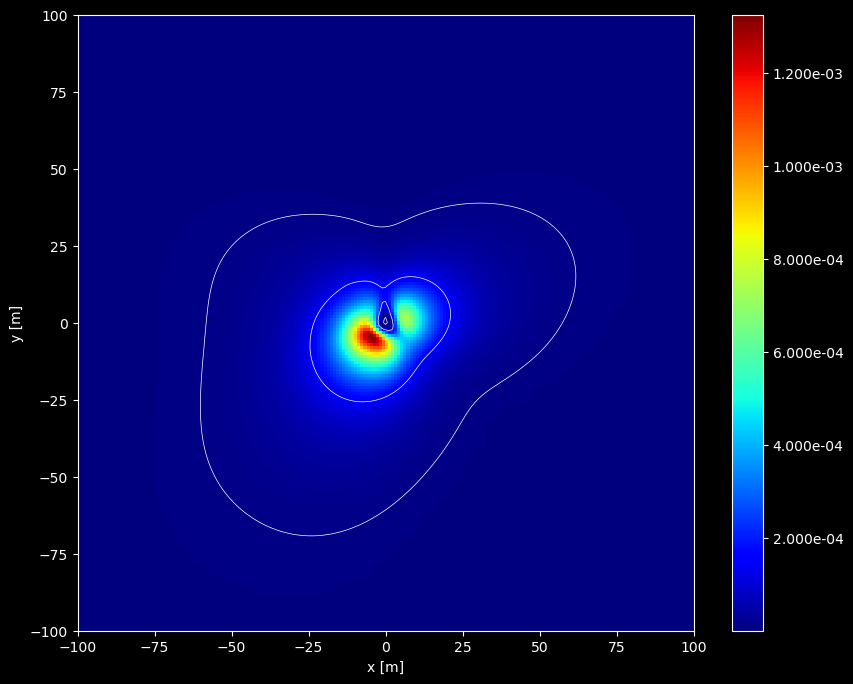

/tmp/ipykernel_14277/1858008836.py:95: RuntimeWarning: invalid value encountered in divide
  fwfm = (ft * fv_m[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)
/tmp/ipykernel_14277/1858008836.py:96: RuntimeWarning: invalid value encountered in divide
  fwfc = (ft * fv_c[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)
/tmp/ipykernel_14277/1858008836.py:97: RuntimeWarning: invalid value encountered in divide
  fwfw = (ft * fv_w[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)


finding fluxes in zones
next month
saving


In [26]:
monthly, FFP = calc_FFP_monthly(l3.loc['2022-06':'2022-06'], soil, zones)

In [35]:
FFP['ftime'][3].sum()

0.8802488593268248

In [31]:
FFP['fclim_2d'].sum()

0.8926515832142157

In [99]:
monthly = read_l3('/home/otto/data/atmos-flux-data/output/csv/atmos_zones_20230705.csv', datecol='date')

M = monthly.merge(zones[['zone', 'geometry']], on='zone', how='left').set_index(monthly.index)
M = gpd.GeoDataFrame(M, geometry = M['geometry'], crs=4326)
M

,date,zone,Tsoil,SWC,fm_mean,geometry
2022-05-01,2022-05-01,0,15.107401,0.371446,NaN,"POLYGON ((-87.99728 41.70120, -87.99756 41.701..."
2022-05-01,2022-05-01,1,15.107401,0.371446,NaN,"POLYGON ((-87.99701 41.70111, -87.99728 41.701..."
2022-05-01,2022-05-01,2,16.393199,0.400718,NaN,"POLYGON ((-87.99673 41.70102, -87.99701 41.701..."
2022-05-01,2022-05-01,3,16.616635,0.415181,NaN,"POLYGON ((-87.99645 41.70093, -87.99673 41.701..."
2022-05-01,2022-05-01,4,16.410205,0.382401,NaN,"POLYGON ((-87.99716 41.70140, -87.99744 41.701..."
...,...,...,...,...,...,...
2023-03-01,2023-03-01,11,NaN,NaN,-0.002015,"POLYGON ((-87.99622 41.70134, -87.99649 41.701..."
2023-03-01,2023-03-01,12,NaN,NaN,-0.003649,"POLYGON ((-87.99692 41.70182, -87.99720 41.701..."
2023-03-01,2023-03-01,13,NaN,NaN,-0.003481,"POLYGON ((-87.99665 41.70173, -87.99692 41.701..."
2023-03-01,2023-03-01,14,NaN,NaN,-0.003028,"POLYGON ((-87.99637 41.70164, -87.99665 41.701..."


In [94]:
monthly.loc['2022-09':'2023-02','Tsoil'].describe()

count    96.000000
mean      7.446941
std       6.003965
min       1.044615
25%       2.524311
50%       6.312028
75%      11.831043
max      18.710454
Name: Tsoil, dtype: float64

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

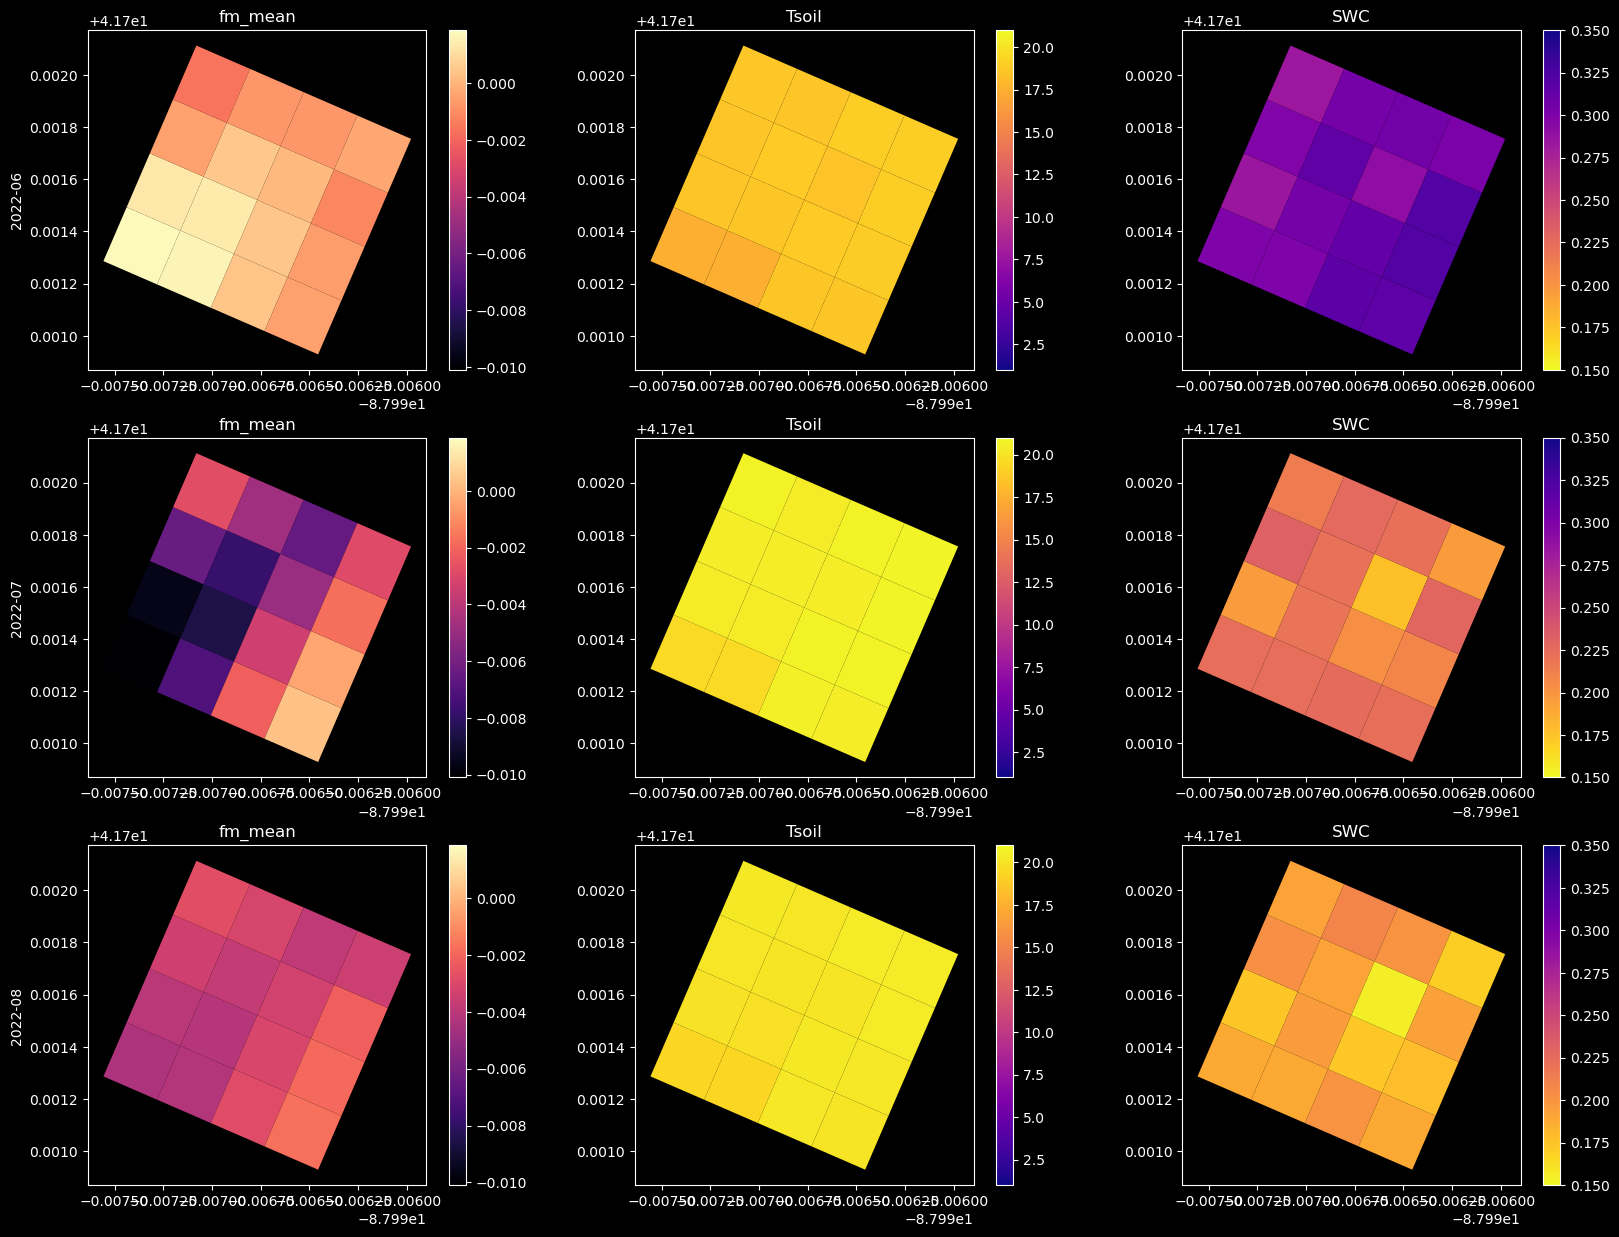

In [100]:
fig, ax = plt.subplots(3,3, figsize = (20,15))

cols = ['fm_mean', 'Tsoil', 'SWC']
cmaps = ['magma', 'plasma', 'plasma_r']
months = monthly.date.dt.to_period('M').astype(str).unique()[1:4]
norms = [plt.Normalize(vmin=monthly['fm_mean'].min(), vmax=monthly['fm_mean'].max()), 
         plt.Normalize(vmin=1, vmax=21), 
         plt.Normalize(vmin=0.15, vmax=0.35), ]
for j in range(len(months)):
    ax[j,0].set_ylabel(months[j])
    for i in range(len(cols)):
        M.loc[months[j],:].plot(column = cols[i], cmap=cmaps[i], legend=True, ax=ax[j,i], norm=norms[i])
        ax[j,i].set_title(cols[i])
# M.loc['2022-09',:].plot(column = 'Tsoil', cmap='inferno', legend=True, ax=ax[1])
# M.loc['2022-09',:].plot(column = 'SWC', cmap='inferno', legend=True, ax=ax[2])
plt.tight_layout()
# plt.savefig(f'/home/otto/data/atmos-flux-data/output/atmos_zonesbymon_{datetime.now().strftime("%Y%m%d")}_{months[0]}-to-{months[len(months)-1]}')

In [107]:
monthly.loc[l3.date.dt.to_period('M').astype(str).unique()[6]]

,zone,Tsoil,SWC,fm_mean
date,,,,
2022-11,0,7.262866,0.316156,NaN
2022-11,1,7.262866,0.316156,NaN
2022-11,2,7.196556,0.317326,NaN
2022-11,3,7.473255,0.297987,NaN
2022-11,4,7.576610,0.308419,NaN
2022-11,5,7.197581,0.346242,NaN
2022-11,6,7.319243,0.315987,NaN
2022-11,7,7.733436,0.299969,NaN
2022-11,8,7.530804,0.333670,NaN


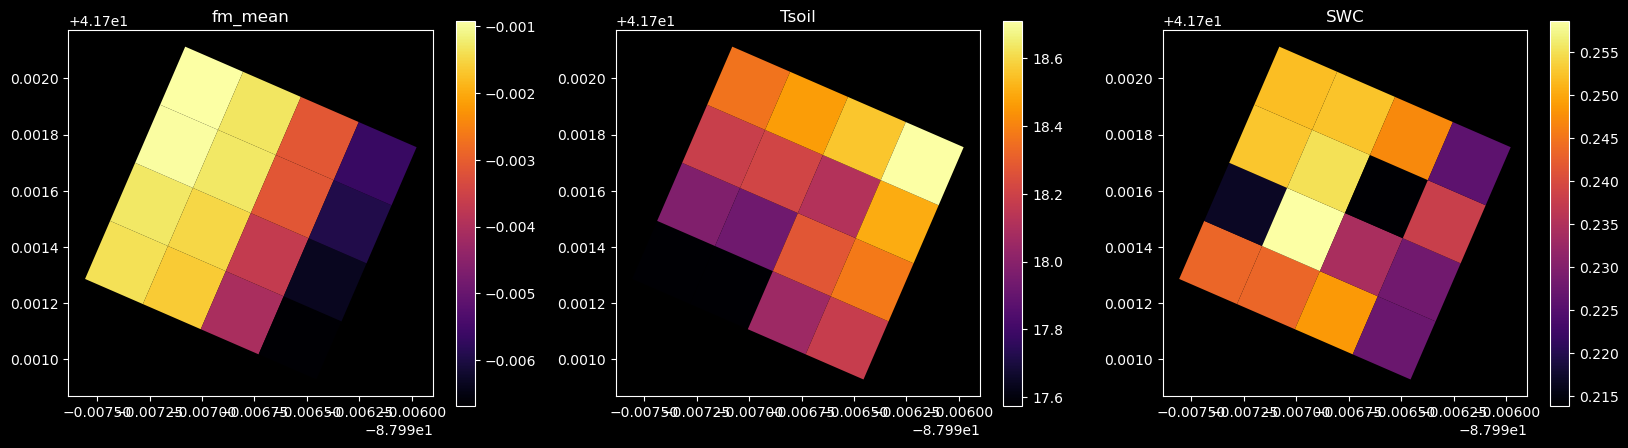

In [83]:
fig, ax = plt.subplots(1,3, figsize = (20,5))
cols = ['fm_mean', 'Tsoil', 'SWC']
for i in range (len(cols)):
    M.loc['2022-09',:].plot(column = cols[i], cmap='inferno', legend=True, ax=ax[i])
    ax[i].set_title(cols[i])
# M.loc['2022-09',:].plot(column = 'Tsoil', cmap='inferno', legend=True, ax=ax[1])
# M.loc['2022-09',:].plot(column = 'SWC', cmap='inferno', legend=True, ax=ax[2])

<Axes: >

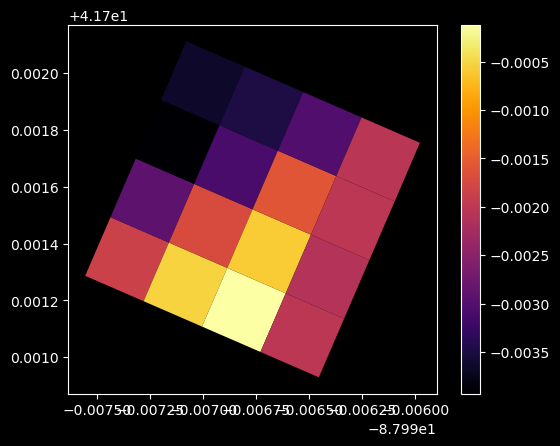

In [23]:
fig, ax = plt.subplots()
monthly.plot(column='fsum_m', cmap='inferno', legend=True, ax = ax)
# FWFS.plot(column = 'fm', cmap = 'viridis',
#           markersize = 0.001,
#           ax=ax)

In [53]:
monthly.loc['2022-05':'2022-07', :]

,zone,Tsoil,SWC,fm_mean
date,,,,
2022-05,0,15.107401,0.371446,0.004154
2022-05,1,15.107401,0.371446,0.002030
2022-05,2,16.393199,0.400718,-0.000703
2022-05,3,16.616635,0.415181,-0.006436
2022-05,4,16.410205,0.382401,0.005843
2022-05,5,16.326840,0.379454,0.003056
2022-05,6,16.258614,0.398088,-0.001530
2022-05,7,16.681564,0.410542,-0.005755
2022-05,8,16.264976,0.371335,0.005604



Alert(0013):
 Using z0, ignoring umean if passed.
 Execution continues.

Calculating footprint  1  of  1058
Calculating footprint  53  of  1058
Calculating footprint  105  of  1058
Calculating footprint  157  of  1058
Calculating footprint  209  of  1058
Calculating footprint  261  of  1058
Calculating footprint  313  of  1058
Calculating footprint  365  of  1058
Calculating footprint  417  of  1058
Calculating footprint  469  of  1058
Calculating footprint  521  of  1058
Calculating footprint  573  of  1058
Calculating footprint  625  of  1058
Calculating footprint  677  of  1058
Calculating footprint  729  of  1058
Calculating footprint  781  of  1058
Calculating footprint  833  of  1058
Calculating footprint  885  of  1058
Calculating footprint  937  of  1058
Calculating footprint  989  of  1058
Calculating footprint  1041  of  1058


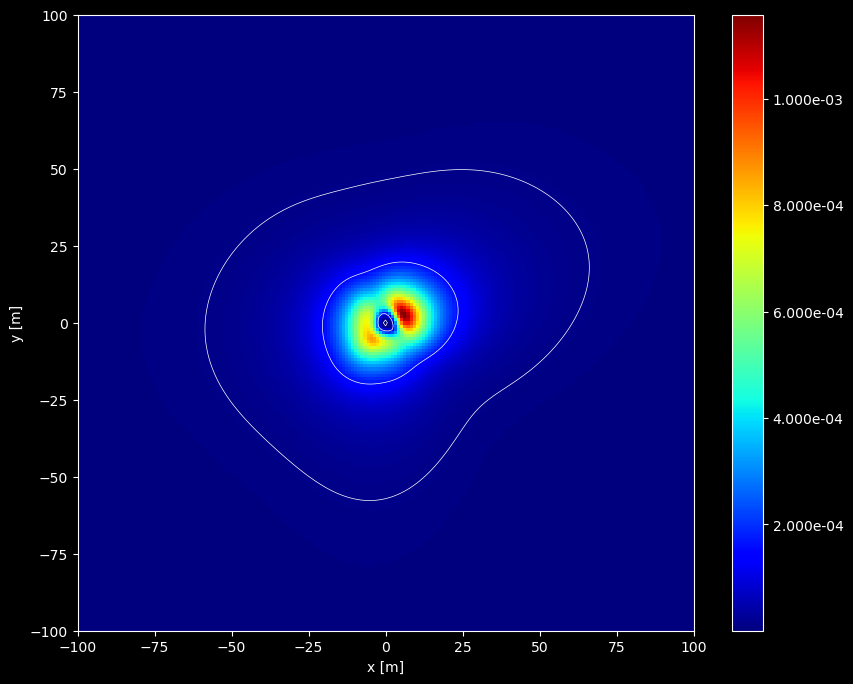

In [13]:
# generate footprints
FFP = myfootprintclim.FFP_climatology(
    zm=zmt,
    z0=z0t,
    umean=None,
    h=ht,
    ol=olt,
    sigmav=sigmavt,
    ustar=ustart,
    wind_dir=wind_dirt,
    domain=domaint,
    nx=nxt,
    rs=rst,
    fig = fig,
    smooth_data=1,
    timeseries=True
)

In [14]:
# georeference grids
x_2d = FFP["x_2d"]
y_2d = FFP["y_2d"]
# set the origin at ATMOS flux tower
origin_lon = -87.996285
origin_lat = 41.701827
x_2d_dd = np.vectorize(get_dd)(x_2d) + origin_lon
y_2d_dd = np.vectorize(get_dd)(y_2d) + origin_lat

# prepare contour inputs
clevs = FFP["fr"][::-1]
clevs = [clev for clev in clevs if clev is not None]
levs = [clev for clev in clevs]
fs = FFP["fclim_2d"]
cs = [cm.jet(ix) for ix in np.linspace(0, 1, len(fs))]
f = fs[0]
c = cs[0]
cc = [c]*len(levs)

# fwfs = np.sum(df['FCH4_F_RF']) * fs

In [16]:
# generate GeoDataFrame of contours
fig, ax = plt.subplots(figsize=(10, 8))
cp = ax.contour(x_2d_dd, y_2d_dd, fs, levs, colors = cc, linewidths=0.5)
gdf = contour_to_gdf(cp)
plt.close()

### Footprint-weighted flux map

For each cell i,j, we multiply the half-hourly flux for half-hour *m* (F_EC*m*) by the half-hourly footprint function for that cell i,j (*f_ijm*), then sum that product for all half-hours. We then divide that sum by the sum of the footprint functions for cell i,j over all half-hours (*f_ijm*).

So, we need to access both the flux and footprint footprint for each half-hour.

In [17]:
ft = FFP['ftime']

# fs = FFP["fclim_2d"]

fv_m = df['FCH4_F_RF'].to_numpy()
fv_c = df['NEE_f'].to_numpy()
fv_w = df['LE_f'].to_numpy()

fwfm = (ft * fv_m[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)
fwfc = (ft * fv_c[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)
fwfw = (ft * fv_w[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)

/tmp/ipykernel_4243/424981659.py:9: RuntimeWarning: invalid value encountered in divide
  fwfm = (ft * fv_m[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)
/tmp/ipykernel_4243/424981659.py:10: RuntimeWarning: invalid value encountered in divide
  fwfc = (ft * fv_c[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)
/tmp/ipykernel_4243/424981659.py:11: RuntimeWarning: invalid value encountered in divide
  fwfw = (ft * fv_w[:, None, None]).sum(axis=0) / np.sum(ft, axis=0)


In [18]:
FWFS = gpd.GeoDataFrame(np.ravel(fwfm), columns = ['fm'], 
                        geometry=gpd.points_from_xy(np.ravel(x_2d_dd), np.ravel(y_2d_dd)), 
                        crs=4326)
FWFS = FWFS.to_crs(3174)

FWFS.geometry = FWFS.geometry.convex_hull.apply(lambda g: g.buffer(distance=1, cap_style=3, join_style=2))

FWFS = FWFS.to_crs(4326)

# FTIME = gpd.GeoDataFrame(np.ravel(fwf), columns = ['fm'], 
#                         geometry=gpd.points_from_xy(np.ravel(x_2d_dd), np.ravel(y_2d_dd)), 
#                         crs=4326))

<Axes: >

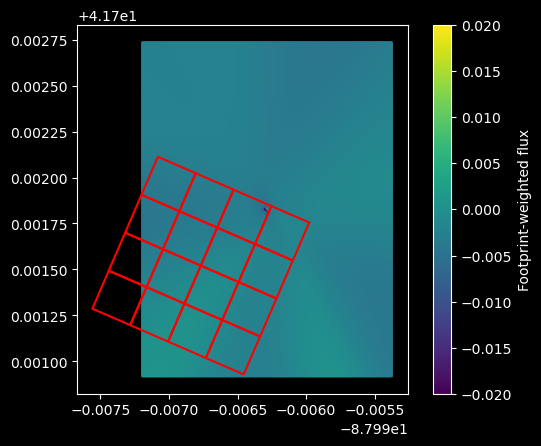

In [19]:
fig, ax = plt.subplots()

FWFS.plot(column='fm', 
          legend = True, 
          vmin = -0.02, 
          vmax = 0.02,
          legend_kwds={"label": "Footprint-weighted flux", "orientation": "vertical"}, 
          ax=ax)

zones.boundary.plot(color = 'red', alpha = 1, ax=ax)

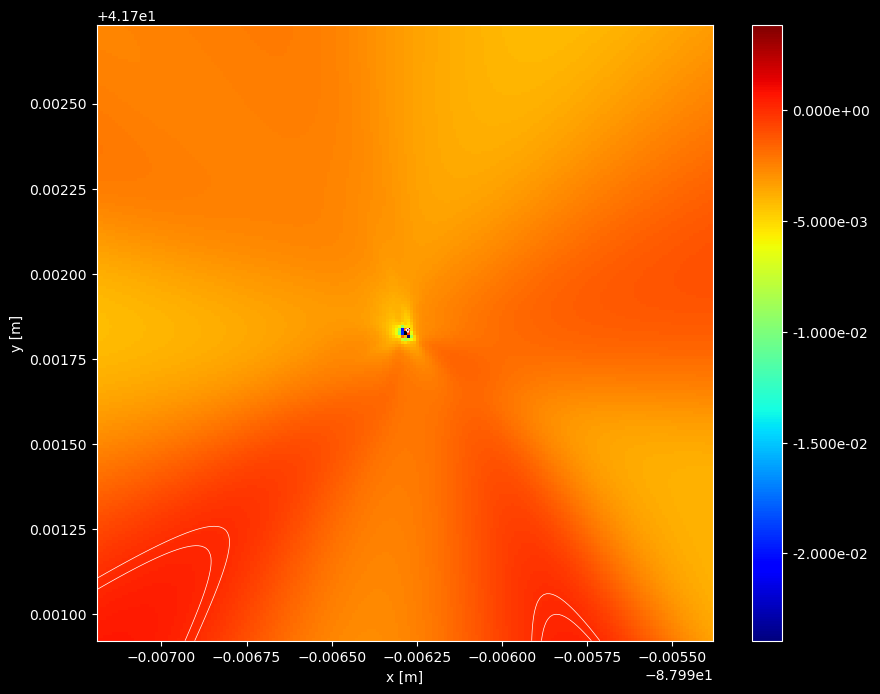

(<Figure size 1000x800 with 2 Axes>, <Axes: xlabel='x [m]', ylabel='y [m]'>)

In [21]:
myfootprintclim.plot_footprint(x_2d=x_2d_dd, y_2d=y_2d_dd, fs=fwfm,
                                        show_heatmap=True,clevs=clevs[::-1])

Sum footprint-weighted fluxes in each zone

In [22]:
zones.loc[:, 'fsum_m'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'fm'].mean() for i in range(16)]
zones.loc[:, 'fsum_m'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'fm'].mean() for i in range(16)]

fp = f'/home/otto/data/atmos-flux-data/output/csv/atmos_zones_{datestart}_{datetime.now().strftime("%Y%m%d")}.csv'
output = zones[['zone', 'geometry', 'Tsoil','SWC','fsum_m']]
# output.to_csv(fp, index=False)

In [88]:
monthly.loc[datestart, 'fm_mean'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'fm'].mean() for i in range(16)]
monthly

,zone,Tsoil,SWC,fsum,fm_mean
date,,,,,
2022-05,0,15.107401,0.371446,NaN,NaN
2022-05,1,15.107401,0.371446,NaN,NaN
2022-05,2,16.393199,0.400718,NaN,NaN
2022-05,3,16.616635,0.415181,NaN,NaN
2022-05,4,16.410205,0.382401,NaN,NaN
...,...,...,...,...,...
2023-03,11,NaN,NaN,-0.002015,-0.002015
2023-03,12,NaN,NaN,-0.003649,-0.003649
2023-03,13,NaN,NaN,-0.003481,-0.003481


<Axes: >

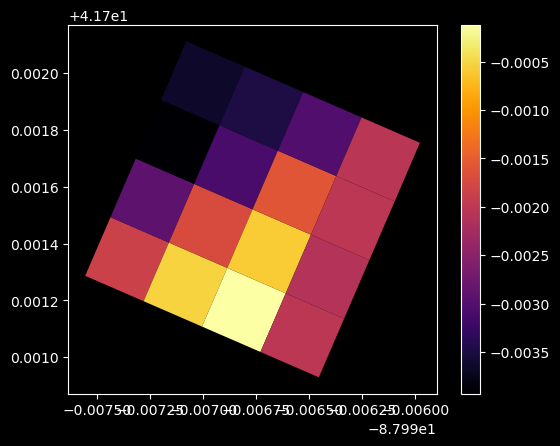

In [23]:
fig, ax = plt.subplots()
zones.plot(column='fsum_m', cmap='inferno', legend=True, ax = ax)
# FWFS.plot(column = 'fm', cmap = 'viridis',
#           markersize = 0.001,
#           ax=ax)

In [75]:
zones

,zone,geometry,logger,serial,status,port,teros_num,x,y,lat,lon,Tsoil,SWC,fsum_m
0,0,"POLYGON ((-87.99728 41.70120, -87.99756 41.701...",1.0,28.0,Active,1,2767,0,0,41.701316,-87.997459,17.445417,0.299912,0.001748
1,1,"POLYGON ((-87.99701 41.70111, -87.99728 41.701...",2.0,17.0,Active,1,2733,2,0,41.701226,-87.997183,17.445417,0.299912,0.001591
2,2,"POLYGON ((-87.99673 41.70102, -87.99701 41.701...",3.0,19.0,Active,1,1983,4,0,41.701137,-87.996907,18.621377,0.317648,0.000420
3,3,"POLYGON ((-87.99645 41.70093, -87.99673 41.701...",4.0,29.0,Active,1,2718,6,0,41.701048,-87.996632,18.649663,0.316163,-0.000488
4,4,"POLYGON ((-87.99716 41.70140, -87.99744 41.701...",1.0,28.0,Active,3,2760,0,2,41.701522,-87.997339,18.535211,0.284072,0.001302
5,5,"POLYGON ((-87.99689 41.70131, -87.99716 41.701...",2.0,17.0,Active,3,2794,2,2,41.701433,-87.997064,18.596282,0.304076,0.001377
6,6,"POLYGON ((-87.99661 41.70122, -87.99689 41.701...",3.0,19.0,Active,3,2709,4,2,41.701344,-87.996788,18.774825,0.313207,0.000440
7,7,"POLYGON ((-87.99634 41.70114, -87.99661 41.701...",4.0,29.0,Active,3,2726,6,2,41.701254,-87.996512,18.822271,0.321825,-0.000580
8,8,"POLYGON ((-87.99704 41.70161, -87.99732 41.701...",5.0,41.0,Active,2,2730,0,4,41.701729,-87.997220,18.517901,0.298866,-0.000506
9,9,"POLYGON ((-87.99677 41.70152, -87.99704 41.701...",5.0,41.0,Active,5,2717,2,4,41.701640,-87.996944,18.734536,0.315364,0.000499


In [328]:
# plotting
origin = gpd.GeoDataFrame(
    {"site": "ATMOS"},
    geometry=gpd.points_from_xy(x=[origin_lon], y=[origin_lat]),
    crs=4326,
    index=[0],
).to_json()
origin = folium.features.GeoJson(origin)

contours = gdf.to_json()
contours = folium.features.GeoJson(contours)

m = folium.Map(location=[origin_lat, origin_lon], zoom_start=16)
m.add_child(origin)
m.add_child(contours)

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

# m.save(f'/home/otto/data/atmos-flux-data/output/html/atmos_ffp_esri_{datestart}-{dateend}_{datetime.now().strftime("%Y%m%d")}')
m

In [76]:
zones

,zone,geometry,logger,serial,status,port,teros_num,x,y,lat,lon,Tsoil,SWC,fsum_m
0,0,"POLYGON ((-87.99728 41.70120, -87.99756 41.701...",1.0,28.0,Active,1,2767,0,0,41.701316,-87.997459,17.445417,0.299912,0.001748
1,1,"POLYGON ((-87.99701 41.70111, -87.99728 41.701...",2.0,17.0,Active,1,2733,2,0,41.701226,-87.997183,17.445417,0.299912,0.001591
2,2,"POLYGON ((-87.99673 41.70102, -87.99701 41.701...",3.0,19.0,Active,1,1983,4,0,41.701137,-87.996907,18.621377,0.317648,0.000420
3,3,"POLYGON ((-87.99645 41.70093, -87.99673 41.701...",4.0,29.0,Active,1,2718,6,0,41.701048,-87.996632,18.649663,0.316163,-0.000488
4,4,"POLYGON ((-87.99716 41.70140, -87.99744 41.701...",1.0,28.0,Active,3,2760,0,2,41.701522,-87.997339,18.535211,0.284072,0.001302
5,5,"POLYGON ((-87.99689 41.70131, -87.99716 41.701...",2.0,17.0,Active,3,2794,2,2,41.701433,-87.997064,18.596282,0.304076,0.001377
6,6,"POLYGON ((-87.99661 41.70122, -87.99689 41.701...",3.0,19.0,Active,3,2709,4,2,41.701344,-87.996788,18.774825,0.313207,0.000440
7,7,"POLYGON ((-87.99634 41.70114, -87.99661 41.701...",4.0,29.0,Active,3,2726,6,2,41.701254,-87.996512,18.822271,0.321825,-0.000580
8,8,"POLYGON ((-87.99704 41.70161, -87.99732 41.701...",5.0,41.0,Active,2,2730,0,4,41.701729,-87.997220,18.517901,0.298866,-0.000506
9,9,"POLYGON ((-87.99677 41.70152, -87.99704 41.701...",5.0,41.0,Active,5,2717,2,4,41.701640,-87.996944,18.734536,0.315364,0.000499


In [30]:
# plotting
origin = gpd.GeoDataFrame(
    {"site": "ATMOS"},
    geometry=gpd.points_from_xy(x=[origin_lon], y=[origin_lat]),
    crs=4326,
    index=[0],
).to_json()
origin = folium.features.GeoJson(origin)

contours = gdf.to_json()
contours = folium.features.GeoJson(contours)

m = folium.Map(location=[origin_lat, origin_lon], zoom_start=16)
m.add_child(origin)
m.add_child(contours)

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

data = pd.DataFrame({'lat': np.ravel(y_2d_dd),
                     'lon': np.ravel(x_2d_dd),
                     'fwfs': np.ravel(fwfc)})

data = data.loc[data['fwfs'].notna()].to_numpy().tolist()

HeatMap(data).add_to(m)

m.save(f'/home/otto/data/atmos-flux-data/output/html/atmos_fwf_esri_{datestart}-{dateend}_{datetime.now().strftime("%Y%m%d")}')
m

In [91]:
# plotting
origin = gpd.GeoDataFrame(
    {"site": "SE-Nor"},
    geometry=gpd.points_from_xy(x=[origin_lon], y=[origin_lat]),
    crs=4326,
    index=[0],
).to_json()
origin = folium.features.GeoJson(origin)

contours = gdf.to_json()
contours = folium.features.GeoJson(contours)

map_osm = folium.Map(location=[origin_lat, origin_lon], zoom_start=16)
map_osm.add_child(origin)
map_osm.add_child(contours)
map_osm.save('/home/otto/data/atmos-flux-data/output/html/atmos_ffp_osm_2022-06')
map_osm

In [4]:
l3.loc['2022-06-01 09:30', ['FCH4_F_RF']]

FCH4_F_RF    0.088184
Name: 2022-06-01 09:30:00, dtype: object

In [5]:
hh_m = '2022-06-01 09:30'

df = l3.loc[hh_m]

ht = 750

zmt = (z_tower - d)

olt = df['L']
sigmavt = df['V_SIGMA']
ustart = df['u.']
wind_dirt = df['wind_dir']
domaint = [-100.0, 100.0, -100.0, 100.0]
nxt = 600
# rst = [20.0, 40.0, 60.0, 80.0]
rst = [50.0, 80.0]

fig = 1

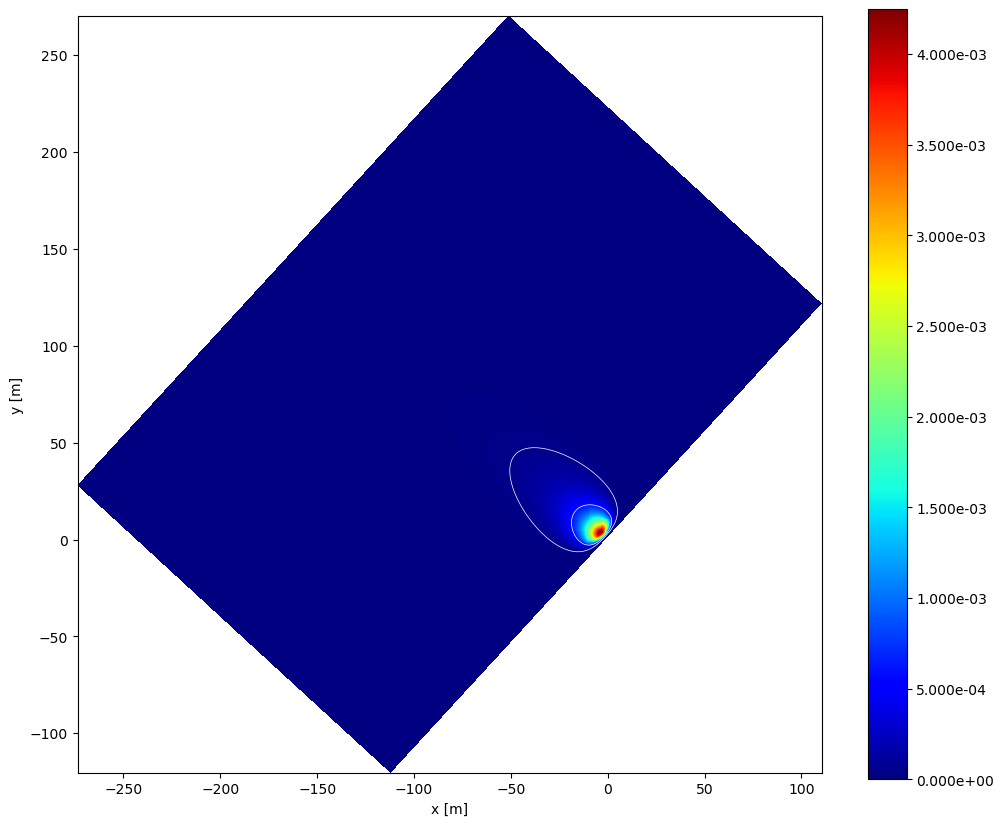

In [6]:
# generate footprints
FFP = myfootprint.FFP(
    zm=zmt,
    z0=z0t,
    umean=None,
    h=ht,
    ol=olt,
    sigmav=sigmavt,
    ustar=ustart,
    wind_dir=wind_dirt,
    domain=domaint,
    nx=nxt,
    rs=rst,
    fig = fig,
    smooth_data=1
)